In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
import gif
from mnist import MNIST
import matplotlib.colors as colors
import matplotlib.cm as cmx
import IPython.display as ipyd
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
mndata = MNIST('datasets_lib/mnist/')

In [3]:
train_X,train_labels = mndata.load_training()

In [4]:
test_X,test_labels = mndata.load_testing()

In [5]:
train_X = np.array(train_X)
train_labels=np.array(train_labels)
test_X=np.array(test_X)
test_labels=np.array(test_labels)

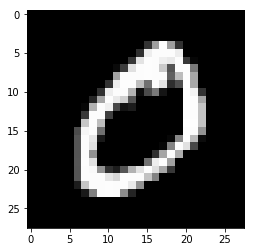

In [6]:
plt.imshow(train_X[1].reshape(28,28),cmap='gray')

In [7]:
mean_img = np.mean(train_X, axis=0)

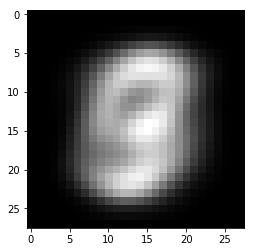

In [10]:
plt.imshow(mean_img.reshape((28,28)),cmap='gray')

In [8]:
std_img = np.std(train_X, axis=0)

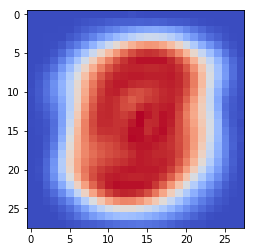

In [12]:
plt.figure()
plt.imshow(std_img.reshape((28,28)),cmap='coolwarm')

In [9]:
from mpl_toolkits.axes_grid1 import AxesGrid


def montageM(fig,nrows,ncols,data,cmap='gray'):
    fig = plt.figure()
    grid = AxesGrid(fig, 111,  # similar to subplot(141)
                        nrows_ncols=(nrows,ncols),
                        axes_pad=0.05,
                        label_mode="1",
                        )
    for i in range(nrows*ncols):
        im = grid[i].imshow(data[i], interpolation="nearest",cmap=cmap)



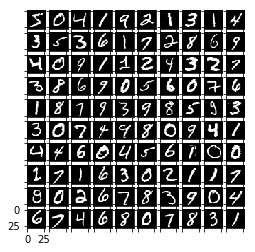

In [28]:

fig=plt.figure()
montageM(fig,nrows=10,ncols=10,data=train_X[:100].reshape(-1,28,28))


In [11]:
dims = [512,256,128,64]

n_features = train_X.shape[1]  # 784

X = tf.placeholder(dtype=tf.float32,shape=[None,n_features])


In [12]:
cur_input=X
n_input=n_features

Ws =[]

for layer_i,n_output in enumerate(dims):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W=tf.get_variable(name='W',shape=[n_input,n_output],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.02))
        h=tf.matmul(cur_input,W)
        
        cur_input=tf.nn.relu(h)
        Ws.append(W)
        n_input=n_output

In [13]:
print(cur_input.get_shape())

(?, 64)


## Now comes the decoder part

In [14]:
Ws = Ws[::-1]
dims = dims[::-1][1:]+[train_X.shape[1]]
print(dims)

[128, 256, 512, 784]


In [15]:
for layer_i,num_outputs in enumerate(dims):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        h = tf.matmul(cur_input,W)
        cur_input = tf.nn.relu(h)
        n_input=num_outputs

Y=cur_input

        

In [16]:
loss = tf.reduce_mean(tf.squared_difference(X,Y),1)

In [17]:
# and then take mean across loss??
loss = tf.reduce_mean(loss)


In [18]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [19]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)


In [20]:
def montage(images, saveto='montage.png'):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto)
    return m

0 2206.15
1 2156.89
2 2132.51
3 2101.87
4 2084.91


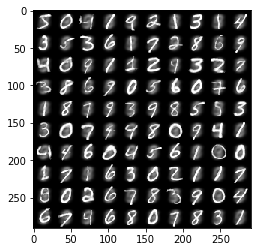

In [30]:
batch_size=100
n_epochs=5

batchInter = train_X.shape[0]/batch_size

#Samples to reconstruct
examples = train_X[:100]

imgs = []
fig,ax = plt.subplots(1,1)
for epoch_i in range(n_epochs):
    for batchOffset in range(batchInter):
        batchX = train_X[batchOffset * batch_size :  (batchOffset+1) * batch_size]
        sess.run(optimizer,feed_dict={X: batchX - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(loss, feed_dict={X: batchX - mean_img}))



(291, 291)


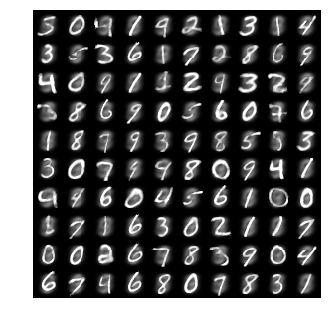

In [22]:
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

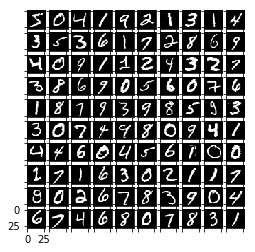

In [31]:
fig=plt.figure()
montageM(fig,nrows=10,ncols=10,data=train_X[:100].reshape(-1,28,28))


In [32]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)